In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:

project_dir = '/content/drive/MyDrive/BrainTumorSeg'
!mkdir -p "{project_dir}"
%cd "{project_dir}"

# After files.upload() gives kaggle.json
!cp kaggle.json "{project_dir}/kaggle.json"

!mkdir -p ~/.kaggle
!cp "{project_dir}/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


/content/drive/MyDrive/BrainTumorSeg
cp: 'kaggle.json' and '/content/drive/MyDrive/BrainTumorSeg/kaggle.json' are the same file


In [ ]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from pycocotools.coco import COCO

# --- Configuration ---
ANNOTATIONS_FILE = '/content/drive/MyDrive/BrainTumorSeg/tumor_dataset/test/_annotations.coco.json'
IMAGES_DIR = '/content/drive/MyDrive/BrainTumorSeg/tumor_dataset/test'
IMG_SIZE       = (128, 128)
BATCH_SIZE     = 8
LEARNING_RATE  = 3e-4
EPOCHS         = 30
AUTOTUNE       = tf.data.AUTOTUNE

# --- GPU Setup ---
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


In [ ]:
# ─── Block 2: COCO Loader ───
coco = COCO(ANNOTATIONS_FILE)
all_ids = coco.getImgIds()

valid_ids = []
for img_id in all_ids:
    info = coco.loadImgs(img_id)
    if not info: continue
    fn = info[0]['file_name']
    if os.path.exists(os.path.join(IMAGES_DIR, fn)):
        valid_ids.append(img_id)
print(f"Filtered {len(valid_ids)}/{len(all_ids)} valid images.")

def load_image_and_mask(img_id):
    info = coco.loadImgs(img_id)[0]
    img = Image.open(os.path.join(IMAGES_DIR, info['file_name'])).convert("RGB")
    img = img.resize(IMG_SIZE, resample=Image.LANCZOS)
    img = np.array(img, np.float32)/127.5 - 1.0

    mask = np.zeros(IMG_SIZE, dtype=np.uint8)
    for ann in coco.loadAnns(coco.getAnnIds(imgIds=img_id)):
        m = coco.annToMask(ann)
        m = np.array(Image.fromarray(m).resize(IMG_SIZE, resample=Image.NEAREST))
        mask = np.maximum(mask, m)
    return img, mask[...,None].astype(np.float32)


loading annotations into memory...
Done (t=1.56s)
creating index...
index created!
Filtered 215/215 valid images.


In [ ]:
def zoom_on_mask_with_coords(img, mask, target_size, zoom_factor=1.5, eps=1e-6):
    """
    img: tf.Tensor shape [H, W, 3], float32
    mask: tf.Tensor shape [H, W, 1], float32 or int, values 0/1
    target_size: tuple (H, W) for the output zoomed crop size
    Returns:
      zoom_img: tf.Tensor [H, W, 3] (resized crop)
      zoom_mask: tf.Tensor [H, W, 1] (resized crop)
      y1, x1, y2, x2: int32 scalar tf.Tensors, coordinates in original image where the crop came from
    """
    # Ensure mask is boolean or numeric
    mask_squeezed = tf.squeeze(mask)  # shape [H, W]
    coords = tf.where(mask_squeezed > 0)  # shape [num_pos, 2]
    H = tf.shape(img)[0]
    W = tf.shape(img)[1]

    # If no positive pixels, return original and a box covering full image
    if tf.shape(coords)[0] < 1:
        # Full image box
        y1 = tf.constant(0, dtype=tf.int32)
        x1 = tf.constant(0, dtype=tf.int32)
        y2 = H
        x2 = W
        # Directly resize full image (though it's same size)
        zoom_img = tf.image.resize(img, target_size)
        zoom_mask = tf.image.resize(mask, target_size, method='nearest')
        return zoom_img, zoom_mask, y1, x1, y2, x2

    # Compute min/max coords
    y_coords = coords[:, 0]
    x_coords = coords[:, 1]
    y_min = tf.cast(tf.reduce_min(y_coords), tf.float32)
    x_min = tf.cast(tf.reduce_min(x_coords), tf.float32)
    y_max = tf.cast(tf.reduce_max(y_coords), tf.float32)
    x_max = tf.cast(tf.reduce_max(x_coords), tf.float32)

    # Center and size
    cy = (y_min + y_max) / 2.0
    cx = (x_min + x_max) / 2.0
    h = (y_max - y_min + eps) * zoom_factor
    w = (x_max - x_min + eps) * zoom_factor

    # Convert to int sizes
    h_int = tf.cast(tf.round(h), tf.int32)
    w_int = tf.cast(tf.round(w), tf.int32)

    # Compute top-left corner
    y1_float = cy - tf.cast(h_int, tf.float32) / 2.0
    x1_float = cx - tf.cast(w_int, tf.float32) / 2.0
    y1 = tf.cast(tf.floor(y1_float), tf.int32)
    x1 = tf.cast(tf.floor(x1_float), tf.int32)

    # Clip to image bounds
    y1 = tf.clip_by_value(y1, 0, H - 1)
    x1 = tf.clip_by_value(x1, 0, W - 1)
    # Compute bottom-right
    y2 = y1 + h_int
    x2 = x1 + w_int
    # Clip bottom-right to bounds
    y2 = tf.clip_by_value(y2, y1 + 1, H)  # ensure at least 1 pixel high
    x2 = tf.clip_by_value(x2, x1 + 1, W)

    # Final crop height/width
    crop_h = y2 - y1
    crop_w = x2 - x1

    # Crop image and mask
    zoom_img_crop = tf.image.crop_to_bounding_box(img, y1, x1, crop_h, crop_w)
    zoom_mask_crop = tf.image.crop_to_bounding_box(mask, y1, x1, crop_h, crop_w)

    # Resize crop to target_size
    zoom_img = tf.image.resize(zoom_img_crop, target_size, method='bilinear')
    zoom_mask = tf.image.resize(zoom_mask_crop, target_size, method='nearest')

    return zoom_img, zoom_mask, y1, x1, y2, x2
# --- Zoom helper (drop-in after your zoom_on_mask_with_coords) ---
def zoom_on_mask(img, mask, target_size, zoom_factor=1.5, eps=1e-6):
    """
    Wrap zoom_on_mask_with_coords, but only return the zoomed img & mask,
    discarding the coords (we only need them at inference time).
    """
    zoom_img, zoom_mask, _, _, _, _ = zoom_on_mask_with_coords(
        img, mask, target_size, zoom_factor, eps
    )
    return zoom_img, zoom_mask


# ─── Block 3: tf.data Pipeline ───
np.random.seed(42)
shuffled = np.random.permutation(valid_ids).tolist()
N = len(shuffled)
train_ids = shuffled[:int(0.7*N)]
val_ids   = shuffled[int(0.7*N):int(0.85*N)]
test_ids  = shuffled[int(0.85*N):]

print(f"Split Train={len(train_ids)}, Val={len(val_ids)}, Test={len(test_ids)}")

def generator(id_list):
    for i in id_list:
        img, mask = load_image_and_mask(i)
        if img is None or mask is None:
            continue
        yield img, mask

def enhanced_augment(img, mask):
    # img, mask are tf.Tensor (float32), already loaded/resized
    # standard flips & color jitter
    if tf.random.uniform(()) > 0.5:
        img, mask = tf.image.flip_left_right(img), tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        img, mask = tf.image.flip_up_down(img), tf.image.flip_up_down(mask)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_contrast(img, 0.9, 1.1)
        img = tf.clip_by_value(img, -1.0, 1.0)
    # always zoom on the tumor region for training:
    img, mask = zoom_on_mask(img, mask, IMG_SIZE)
    return img, mask

def make_ds(ids, augment=True):
    ds = tf.data.Dataset.from_generator(
        lambda: generator(ids),
        output_signature=(
            tf.TensorSpec([*IMG_SIZE,3],tf.float32),
            tf.TensorSpec([*IMG_SIZE,1],tf.float32),
        )
    )
    if augment:
        ds = ds.map(enhanced_augment, num_parallel_calls=AUTOTUNE)
    ds = ds.repeat().cache().shuffle(500).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_ids, augment=True)
val_ds   = make_ds(val_ids,   augment=False)   # still zoom-only, but no random flips
test_ds  = make_ds(test_ids,  augment=False)

steps_per_epoch  = max(1, len(train_ids)//BATCH_SIZE)
validation_steps = max(1, len(val_ids)//BATCH_SIZE)


Split Train=150, Val=32, Test=33


In [ ]:
# ───── Block 4:  U-Net Architecture ─────
def conv_block(x, filters, dropout_rate=0.1):
    """Enhanced convolution block with batch normalization"""
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    if dropout_rate > 0:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

def attention_gate(g, x, filters):
    """Improved attention gate"""
    g1 = tf.keras.layers.Conv2D(filters, 1)(g)
    g1 = tf.keras.layers.BatchNormalization()(g1)

    x1 = tf.keras.layers.Conv2D(filters, 1)(x)
    x1 = tf.keras.layers.BatchNormalization()(x1)

    psi = tf.keras.layers.Activation('relu')(tf.keras.layers.add([g1, x1]))
    psi = tf.keras.layers.Conv2D(1, 1)(psi)
    psi = tf.keras.layers.BatchNormalization()(psi)
    psi = tf.keras.layers.Activation('sigmoid')(psi)

    return tf.keras.layers.multiply([x, psi])

def build_enhanced_unet(input_shape=(128, 128, 3)):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder - Optimized for 128x128 and Colab
    c1 = conv_block(inputs, 32, 0.1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 64, 0.1)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 128, 0.2)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck - Reduced complexity for faster training
    c4 = conv_block(p3, 256, 0.2)

    # Decoder with attention gates - 3 levels instead of 4
    u5 = tf.keras.layers.UpSampling2D((2, 2))(c4)
    u5 = tf.keras.layers.Conv2D(128, 2, activation='relu', padding='same')(u5)
    a5 = attention_gate(u5, c3, 128)
    m5 = tf.keras.layers.concatenate([u5, a5])
    c5 = conv_block(m5, 128, 0.2)

    u6 = tf.keras.layers.UpSampling2D((2, 2))(c5)
    u6 = tf.keras.layers.Conv2D(64, 2, activation='relu', padding='same')(u6)
    a6 = attention_gate(u6, c2, 64)
    m6 = tf.keras.layers.concatenate([u6, a6])
    c6 = conv_block(m6, 64, 0.1)

    u7 = tf.keras.layers.UpSampling2D((2, 2))(c6)
    u7 = tf.keras.layers.Conv2D(32, 2, activation='relu', padding='same')(u7)
    a7 = attention_gate(u7, c1, 32)
    m7 = tf.keras.layers.concatenate([u7, a7])
    c7 = conv_block(m7, 32, 0.1)

    outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(c7)

    model = tf.keras.Model(inputs, outputs)   # ← no square braces
    return model

In [ ]:
def calculate_class_weights(ids, clip_max=10.0):
    fg = 0.0
    valid_count = 0
    pix = IMG_SIZE[0] * IMG_SIZE[1]
    sample_n = min(len(ids), 500)
    if sample_n == 0:
        raise ValueError("No IDs provided for class weight calculation.")
    for img_id in ids[:sample_n]:
        img, m = load_image_and_mask(img_id)
        if img is None or m is None:
            continue
        fg += m.sum()
        valid_count += 1
    if valid_count == 0:
        raise ValueError("Unable to load any masks for weight calculation.")
    total_pixels = pix * valid_count
    bg_pixels = total_pixels - fg
    wfg = 1.0 if fg <= 0 else np.clip(bg_pixels / fg, 1.0, clip_max)
    return 1.0, float(wfg)

weight_bg, weight_fg = calculate_class_weights(train_ids)
print(f"Weights: bg={weight_bg}, fg={weight_fg}")

Weights: bg=1.0, fg=10.0


In [ ]:
# ─── Block 5: Weighted Loss + Capped Weight & Adjusted Tversky ───


def weighted_binary_dice(y_true, y_pred, smooth=1e-6):
    w = y_true * weight_fg + (1 - y_true) * weight_bg
    yt = y_true * w
    yp = y_pred * w
    inter = tf.reduce_sum(yt * yp)
    denom = tf.reduce_sum(yt) + tf.reduce_sum(yp)
    return (2*inter + smooth) / (denom + smooth)


def tversky_loss(y_true, y_pred, alpha=0.3, beta=0.7, smooth=1e-6):
    """Now penalizes false positives more (beta>.5)."""
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    TP = tf.reduce_sum(y_true_f * y_pred_f)
    FP = tf.reduce_sum((1 - y_true_f) * y_pred_f)
    FN = tf.reduce_sum(y_true_f * (1 - y_pred_f))
    return 1 - (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)


def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    eps = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, eps, 1-eps)
    ce = -y_true*tf.math.log(y_pred) - (1-y_true)*tf.math.log(1-y_pred)
    return tf.reduce_mean(alpha * tf.pow(1-y_pred, gamma) * ce)


def weighted_combined_loss(y_true, y_pred):
    return (
        0.4 * (1 - weighted_binary_dice(y_true, y_pred)) +
        0.3 * tversky_loss(y_true, y_pred) +
        0.3 * focal_loss(y_true, y_pred)
    )


In [ ]:
# ─── Block 6: Training Setup with Standard Dice/IoU for Monitoring ───
model = build_enhanced_unet((128, 128, 3))
model.summary()

# Define easy-to-interpret metrics in [0,1]
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    return (2*inter + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss=weighted_combined_loss,
    metrics=[dice_coef, iou_score]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_dice_coef', patience=10, mode='max',
        restore_best_weights=True, verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7, verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',  # use native Keras format now
        monitor='val_dice_coef', mode='max', save_best_only=True, verbose=1
    )
]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ dropout_1[0][0] 

 Total params: 1,976,720 (7.54 MB)

 Trainable params: 1,973,002 (7.53 MB)

 Non-trainable params: 3,718 (14.52 KB)

In [ ]:
# ─── Block 7: Training ───
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.6109 - iou_score: 0.4473 - loss: -2.5235
Epoch 1: val_dice_coef improved from -inf to 0.08141, saving model to best_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 209s 9s/step - dice_coef: 0.6158 - iou_score: 0.4528 - loss: -2.5419 - val_dice_coef: 0.0814 - val_iou_score: 0.0426 - val_loss: -0.8810 - learning_rate: 3.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.8660 - iou_score: 0.7641 - loss: -3.3700
Epoch 2: val_dice_coef improved from 0.08141 to 0.14104, saving model to best_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 131s 7s/step - dice_coef: 0.8668 - iou_score: 0.7655 - loss: -3.3713 - val_dice_coef: 0.1410 - val_iou_score: 0.0766 - val_loss: -1.5407 - learning_rate: 3.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - dice_coef: 0.8987 - iou_score: 0.8162 - loss: -3.4171
Epoch 3: val_dice_coef improved from 0.14104 to 0.17177, saving model to best_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 142s 8s

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.morphology import opening, disk

def post_process_prediction(pred, threshold=0.5, min_area=20):
    binp = (pred > threshold).astype(np.uint8)
    binp = opening(binp, disk(3))
    labeled, n = ndimage.label(binp)
    if n == 0:
        return binp
    areas = ndimage.sum(binp, labeled, range(1, n+1))
    keep = [i+1 for i,a in enumerate(areas) if a >= min_area]
    out = np.zeros_like(binp, dtype=np.uint8)
    for lbl in keep:
        out[labeled == lbl] = 1
    return out

def overlay_mask_on_image(image, mask, color=(1,0,0), alpha=0.3):
    img = image.copy()
    overlay = np.zeros_like(img)
    for c in range(3):
        overlay[..., c] = color[c]
    mask_bool = mask.astype(bool)
    img[mask_bool] = (1 - alpha) * img[mask_bool] + alpha * overlay[mask_bool]
    return img

def visualize_zoom_with_failsafe(model, test_ds, num_samples=5, IMG_SIZE=(128,128), zoom_factor=1.5):
    fig, axes = plt.subplots(num_samples, 5, figsize=(5*4, 4*num_samples))  # 5 columns
    sample_count = 0

    for batch_images, batch_masks in test_ds.take(1):
        for i in range(min(num_samples, batch_images.shape[0])):
            img_tf = batch_images[i]
            mask_tf = batch_masks[i]
            img_np = ((img_tf + 1)/2).numpy()
            mask_np = mask_tf.numpy().squeeze()

            # 1) Zoom crop + coords
            zoom_img_tf, zoom_mask_tf, y1, x1, y2, x2 = zoom_on_mask_with_coords(
                img_tf, mask_tf, IMG_SIZE, zoom_factor
            )
            zoom_img_np = ((zoom_img_tf + 1)/2).numpy()

            # 2) Predict on zoom crop
            pred_zoom = model.predict(zoom_img_tf[None,...])[0,...,0]
            post_zoom = post_process_prediction(pred_zoom)

            # 3) Map back to full
            mapped = map_zoom_mask_to_full(pred_zoom,
                                           int(y1.numpy()), int(x1.numpy()),
                                           int(y2.numpy()), int(x2.numpy()),
                                           full_size=IMG_SIZE)
            post_mapped = post_process_prediction(mapped)

            # 4) Fail-safe: if mapped is empty, use full-image
            if post_mapped.sum() == 0:
                full_pred = model.predict(img_tf[None,...])[0,...,0]
                final_mask = post_process_prediction(full_pred)
                used = 'full-image fallback'
            else:
                final_mask = post_mapped
                used = 'zoom path'

            # Overlays
            overlay_gt     = overlay_mask_on_image(img_np, mask_np,     color=(1,1,0), alpha=0.3)
            overlay_zoom   = overlay_mask_on_image(zoom_img_np, post_zoom, color=(0,1,0), alpha=0.3)
            overlay_final  = overlay_mask_on_image(img_np, final_mask,  color=(1,0,0), alpha=0.3)

            ax = axes[sample_count]
            # Col 0: Original Image
            ax[0].imshow(img_np)
            ax[0].set_title('Original Image')
            ax[0].axis('off')

            # Col 1: Ground Truth
            ax[1].imshow(overlay_gt)
            ax[1].set_title('Ground Truth Mask')
            ax[1].axis('off')

            # Col 2: Zoom crop
            ax[2].imshow(zoom_img_np)
            ax[2].set_title('Zoom Crop')
            ax[2].axis('off')

            # Col 3: Zoom prediction overlay
            ax[3].imshow(overlay_zoom)
            ax[3].set_title('Zoom Pred Overlay')
            ax[3].axis('off')

            # Col 4: Final overlay on full image
            ax[4].imshow(overlay_final)
            ax[4].set_title(f'Final Output ({used})')
            ax[4].axis('off')

            sample_count += 1
            if sample_count >= num_samples:
                break

    plt.tight_layout()
    plt.show()


In [ ]:
def map_zoom_mask_to_full(pred_zoom, y1, x1, y2, x2, full_size=(128,128)):
    zoom_h, zoom_w = y2 - y1, x2 - x1
    resized_pred = tf.image.resize(pred_zoom[..., None], (zoom_h, zoom_w), method='nearest').numpy().squeeze()

    full_mask = np.zeros(full_size, dtype=np.float32)
    full_mask[y1:y2, x1:x2] = resized_pred
    return full_mask


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


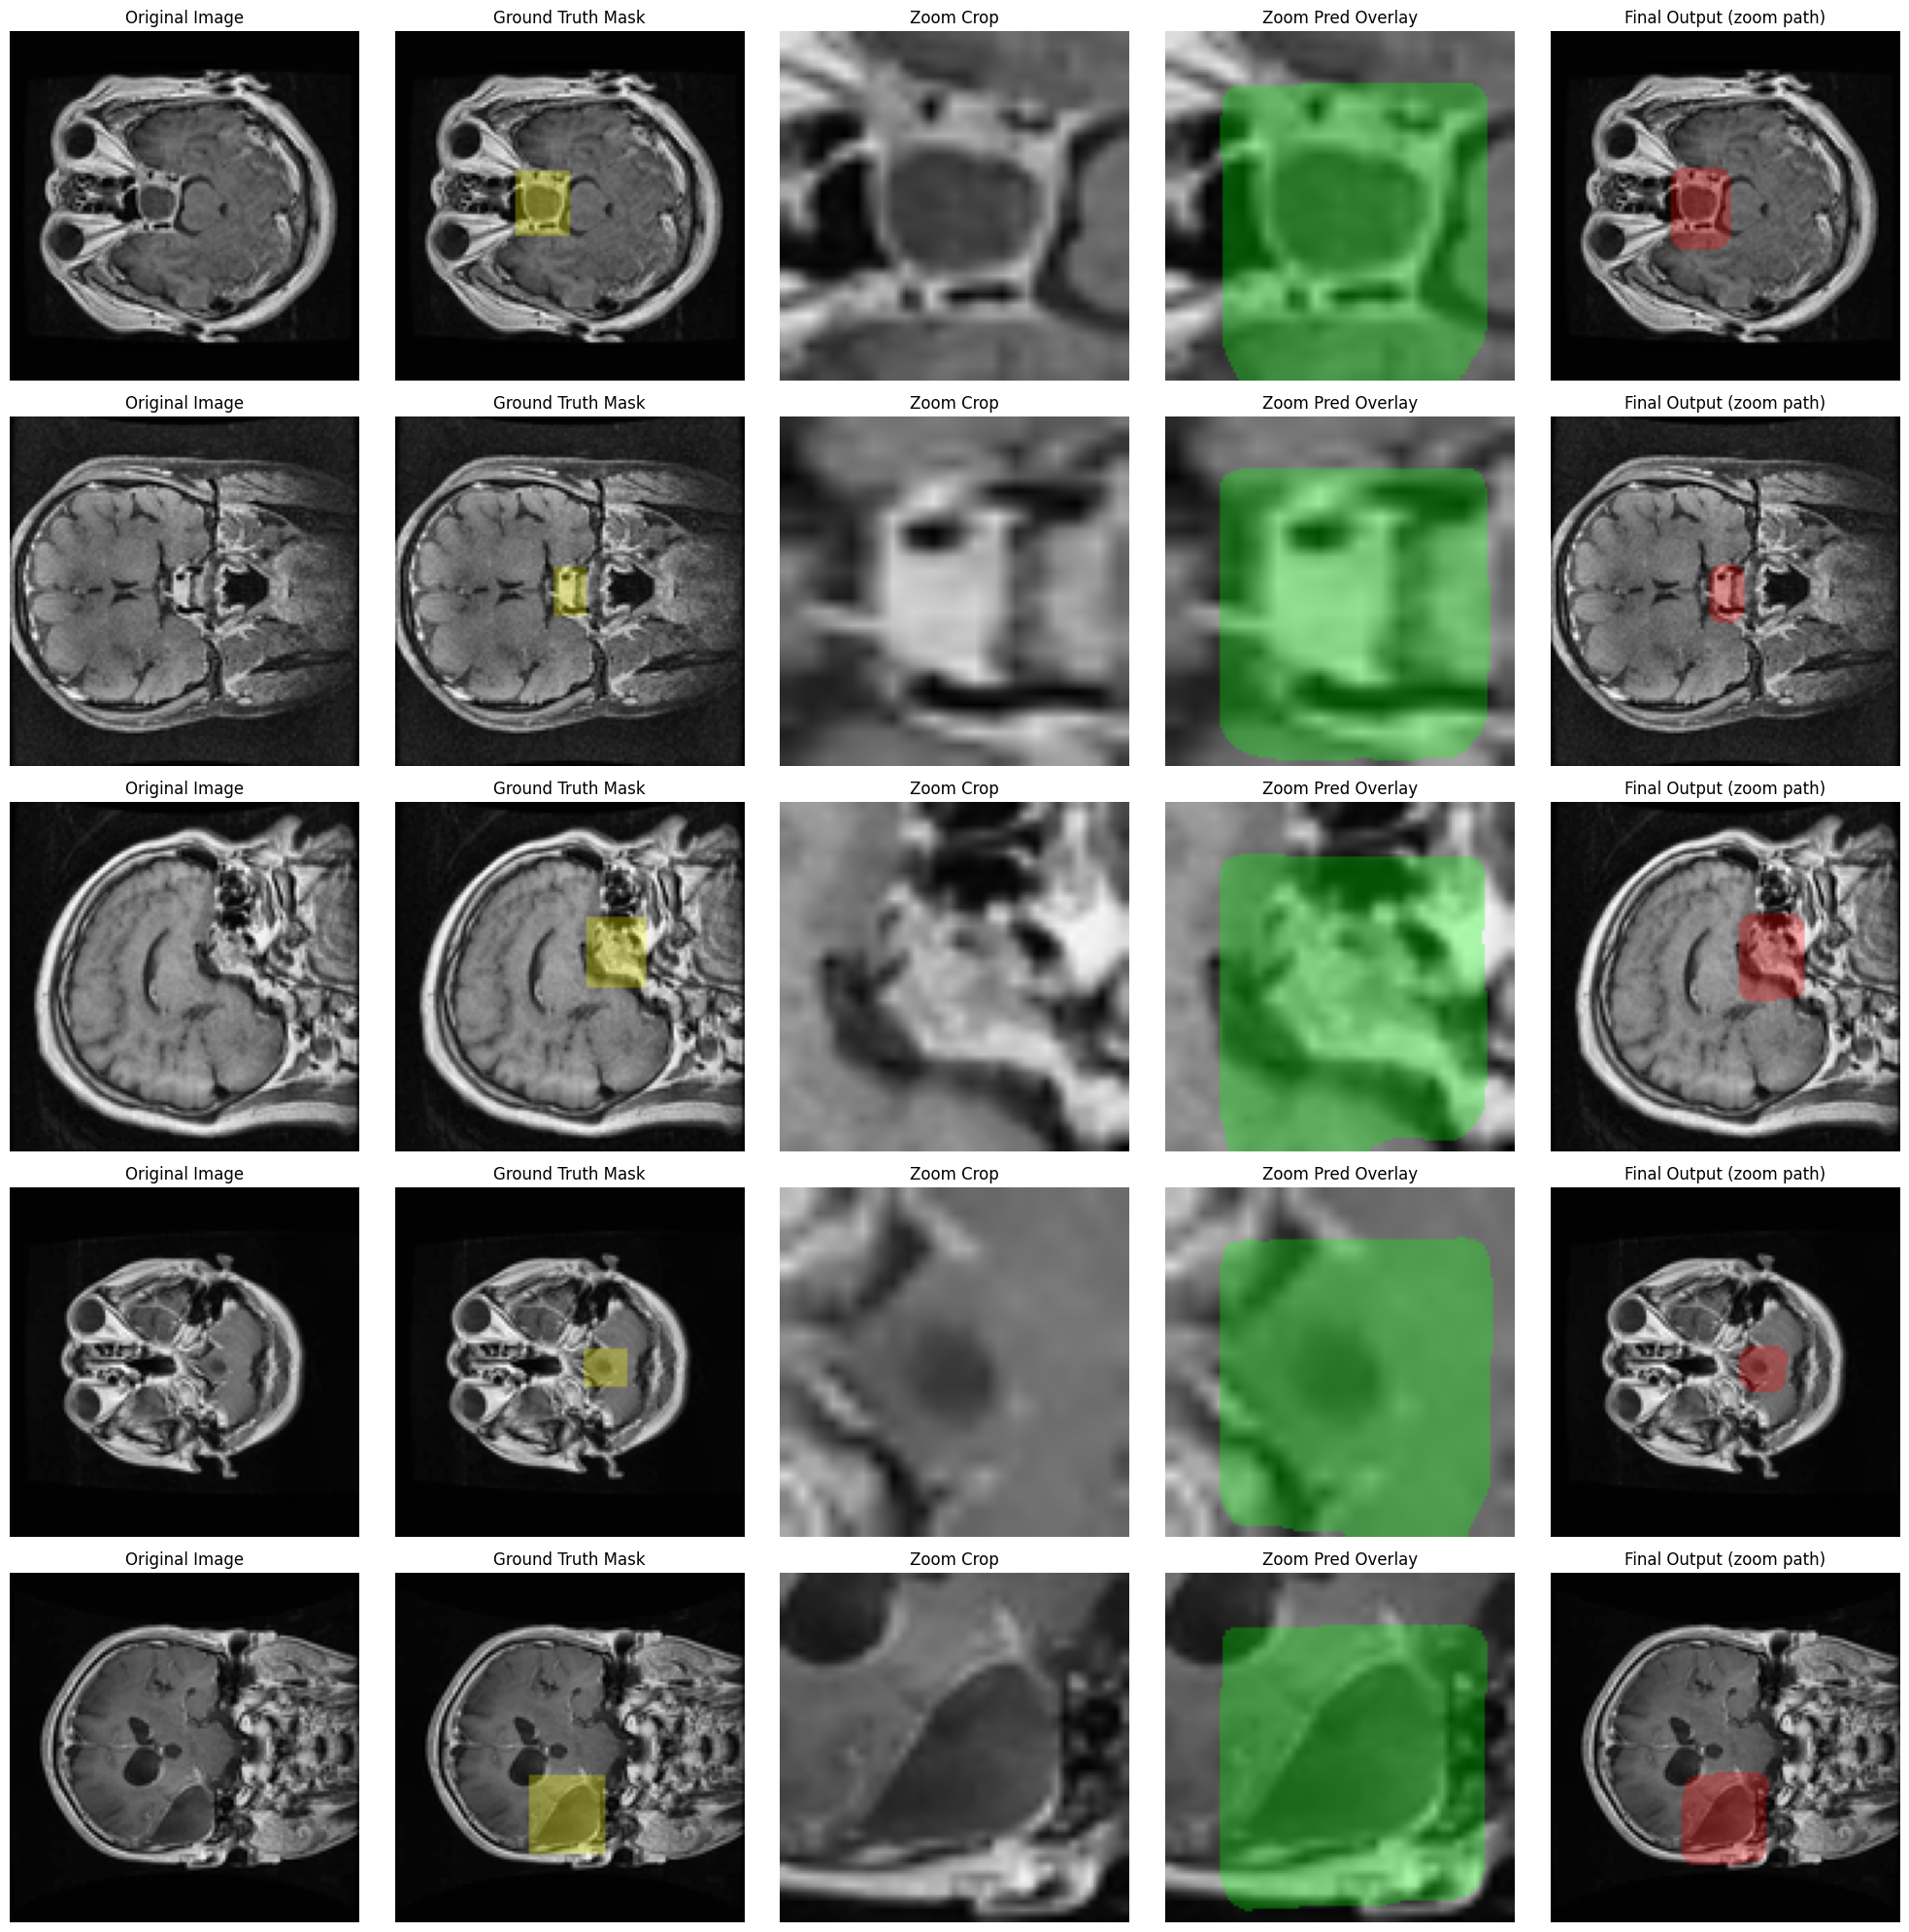

In [ ]:
visualize_zoom_with_failsafe(model, test_ds, num_samples=5)
